In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os

In [ ]:
base_dir_image = "/content/drive/MyDrive/Colab Notebooks/dataset/intel-image-classification/seg_train/seg_train"
os.listdir(base_dir_image)
#"cane": "dog",
#"cavallo": "horse",
#"elefante": "elephant",
#"farfalla": "butterfly",
#"gallina": "chicken",
#"gatto": "cat",
#"mucca": "cow",
#"pecora": "sheep",
#"scoiattolo": "squirrel",
#"ragno": "spider"

['glacier', 'mountain', 'sea', 'street', 'buildings', 'forest']

In [ ]:
batch_size = 32
img_size = 224

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.2)

train_generator = train_datagen.flow_from_directory(base_dir_image,
                                                target_size=(img_size, img_size),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')

validation_generator = train_datagen.flow_from_directory(base_dir_image,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (img_size,img_size,3))

model = tf.keras.models.Sequential([
          base_model,
          tf.keras.layers.MaxPooling2D(2,2),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512,'relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(6, activation='softmax')
          ])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 512)               2359808   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 30

In [ ]:
model_name = "/content/drive/MyDrive/Colab Notebooks/dataset/intel-image-classification/model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
            print("\naccuracy di atas 0.92 dan val_accuracy di atas 0.92, berhenti!")
            self.model.stop_training = True
my_callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    batch_size = 128,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,my_callbacks,learning_rate_reduction],
                    steps_per_epoch=100)

Epoch 1/15
100/100 [==============================] - ETA: 0s - loss: 1.0572 - accuracy: 0.5753 
Epoch 1: val_loss improved from inf to 0.61938, saving model to /content/drive/MyDrive/Colab Notebooks/dataset/intel-image-classification/model.h5
100/100 [==============================] - 4988s 50s/step - loss: 1.0572 - accuracy: 0.5753 - val_loss: 0.6194 - val_accuracy: 0.7675 - lr: 1.0000e-04
Epoch 2/15
100/100 [==============================] - ETA: 0s - loss: 0.6323 - accuracy: 0.7652 
Epoch 2: val_loss improved from 0.61938 to 0.51161, saving model to /content/drive/MyDrive/Colab Notebooks/dataset/intel-image-classification/model.h5
100/100 [==============================] - 1937s 19s/step - loss: 0.6323 - accuracy: 0.7652 - val_loss: 0.5116 - val_accuracy: 0.8160 - lr: 1.0000e-04
Epoch 3/15
100/100 [==============================] - ETA: 0s - loss: 0.5169 - accuracy: 0.8158 
Epoch 3: val_loss improved from 0.51161 to 0.42814, saving model to /content/drive/MyDrive/Colab Notebooks/da

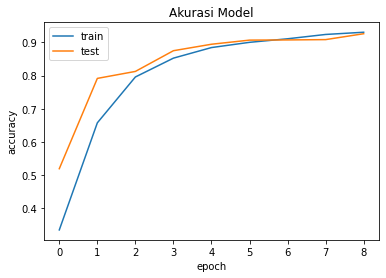

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

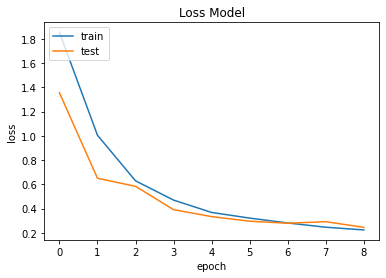

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
export_dir = '/content/drive/MyDrive/Colab Notebooks/animal/saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/animal/animal.tflite')
tflite_model_file.write_bytes(tflite_model)

68327788

sapi


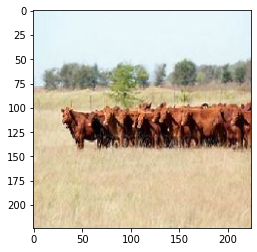

In [ ]:
path = "/content/animals10/raw-img/sapi/OIP---lAIbDlHKmejDpqrXq6vAAAAA.jpeg"
img = image.load_img(path, target_size=(224,224))

imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=1)
if classes[0][0]==1:
  print('anjing')
elif classes[0][1]==1:
  print('ayam')
elif classes[0][2]==1:
  print('domba')
elif classes[0][3]==1:
  print('gajah')
elif classes[0][4]==1:
  print('kucing')
elif classes[0][5]==1:
  print('kuda')
elif classes[0][6]==1:
  print('kupu_kupu')
elif classes[0][7]==1:
  print('laba_laba')
elif classes[0][8]==1:
  print('sapi')
elif classes[0][9]==1:
  print('tupai')